In [2]:
#IMPORTS
import pandas as pd
import logging
import torch
from collections import Counter
from ast import literal_eval
import torch
from urllib import request
import random
# device = torch.device("cpu")

In [3]:
# # prepare logger
# logging.basicConfig(level=logging.INFO)

# transformers_logger = logging.getLogger("transformers")
# transformers_logger.setLevel(logging.WARNING)

# # check gpu
# cuda_available = torch.cuda.is_available()

# print('Cuda available? ',cuda_available)
# if cuda_available:
#   import tensorflow as tf
#   # Get the GPU device name.
#   device_name = tf.test.gpu_device_name()
#   # The device name should look like the following:
#   if device_name == '/device:GPU:0':
#       print('Found GPU at: {}'.format(device_name))
#   else:
#       raise SystemError('GPU device not found')

In [4]:
module_url = f"https://raw.githubusercontent.com/Perez-AlmendrosC/dontpatronizeme/master/semeval-2022/dont_patronize_me.py"
module_name = module_url.split('/')[-1]
print(f'Fetching {module_url}')
#with open("file_1.txt") as f1, open("file_2.txt") as f2
with request.urlopen(module_url) as f, open(module_name,'w') as outf:
  a = f.read()
  outf.write(a.decode('utf-8'))

# helper function to save predictions to an output file
def labels2file(p, outf_path):
	with open(outf_path,'w') as outf:
		for pi in p:
			outf.write(','.join([str(k) for k in pi])+'\n')

Fetching https://raw.githubusercontent.com/Perez-AlmendrosC/dontpatronizeme/master/semeval-2022/dont_patronize_me.py


In [5]:
from dont_patronize_me import DontPatronizeMe
dpm = DontPatronizeMe('.', '.')
dpm.load_task1()
dpm.load_task2(return_one_hot=True)

Map of label to numerical label:
{'Unbalanced_power_relations': 0, 'Shallow_solution': 1, 'Presupposition': 2, 'Authority_voice': 3, 'Metaphors': 4, 'Compassion': 5, 'The_poorer_the_merrier': 6}


In [264]:
trids = pd.read_csv('train_semeval_parids-labels.csv')
teids = pd.read_csv('dev_semeval_parids-labels.csv')

trids.par_id = trids.par_id.astype(str)
teids.par_id = teids.par_id.astype(str)

data=dpm.train_task1_df
data

,par_id,art_id,keyword,country,text,label,orig_label,pcl_strength,pcl_val
0,1,@@24942188,hopeless,ph,"We 're living in times of absolute insanity , ...",0,0,0,0
1,2,@@21968160,migrant,gh,"In Libya today , there are countless number of...",0,0,0,0
2,3,@@16584954,immigrant,ie,"""White House press secretary Sean Spicer said ...",0,0,0,0
3,4,@@7811231,disabled,nz,Council customers only signs would be displaye...,0,0,0,0
4,5,@@1494111,refugee,ca,""""""" Just like we received migrants fleeing El ...",0,0,0,0
...,...,...,...,...,...,...,...,...,...
10464,10465,@@14297363,women,lk,"""Sri Lankan norms and culture inhibit women fr...",0,1,0,1
10465,10466,@@70091353,vulnerable,ph,He added that the AFP will continue to bank on...,0,0,0,0
10466,10467,@@20282330,in-need,ng,""""""" She has one huge platform , and informatio...",1,3,0,3
10467,10468,@@16753236,hopeless,in,""""""" Anja Ringgren Loven I ca n't find a word t...",1,4,0,4


In [265]:

rows = [] # will contain par_id, label and text
for idx in range(len(trids)):  
  parid = trids.par_id[idx]
  #print(parid)
  # select row from original dataset to retrieve `text` and binary label
  keyword = data.loc[data.par_id == parid].keyword.values[0]
  text = data.loc[data.par_id == parid].text.values[0]
  label = data.loc[data.par_id == parid].label.values[0]
  orig_label = data.loc[data.par_id == parid].orig_label.values[0]
  item = {
      'par_id':parid,
      'community':keyword,
      'text':text,
      'label':label,
      'orig_label': orig_label
  }
  rows.append(item)

In [271]:
trdf1 = pd.DataFrame(rows)
trdf1

,par_id,community,text,label,orig_label
0,4341,poor-families,"The scheme saw an estimated 150,000 children f...",1,4
1,4136,homeless,Durban 's homeless communities reconciliation ...,1,2
2,10352,poor-families,The next immediate problem that cropped up was...,1,4
3,8279,vulnerable,Far more important than the implications for t...,1,2
4,1164,poor-families,To strengthen child-sensitive social protectio...,1,4
...,...,...,...,...,...
8370,8380,refugee,Rescue teams search for survivors on the rubbl...,0,0
8371,8381,hopeless,The launch of ' Happy Birthday ' took place la...,0,0
8372,8382,homeless,"The unrest has left at least 20,000 people dea...",0,0
8373,8383,hopeless,You have to see it from my perspective . I may...,0,0


In [272]:
test_rows = [] # will contain par_id, label and text
for idx in range(len(teids)):  
  parid = teids.par_id[idx]
  #print(parid)
  # select row from original dataset
  keyword = data.loc[data.par_id == parid].keyword.values[0]
  text = data.loc[data.par_id == parid].text.values[0]
  label = data.loc[data.par_id == parid].label.values[0]
  orig_label = data.loc[data.par_id == parid].orig_label.values[0]
  test_rows.append({
      'par_id':parid,
      'community':keyword,
      'text':text,
      'label':label,
      'orig_label': orig_label
  })
  #TODO: keyword?Country?length?

In [273]:
tedf1 = pd.DataFrame(rows)
tedf1

,par_id,community,text,label,orig_label
0,4341,poor-families,"The scheme saw an estimated 150,000 children f...",1,4
1,4136,homeless,Durban 's homeless communities reconciliation ...,1,2
2,10352,poor-families,The next immediate problem that cropped up was...,1,4
3,8279,vulnerable,Far more important than the implications for t...,1,2
4,1164,poor-families,To strengthen child-sensitive social protectio...,1,4
...,...,...,...,...,...
8370,8380,refugee,Rescue teams search for survivors on the rubbl...,0,0
8371,8381,hopeless,The launch of ' Happy Birthday ' took place la...,0,0
8372,8382,homeless,"The unrest has left at least 20,000 people dea...",0,0
8373,8383,hopeless,You have to see it from my perspective . I may...,0,0


In [296]:
tedf1 = tedf1.sample(frac = 1) # shuffle data
# downsample negative instances
pcldf = trdf1[trdf1.label==1]
npos = len(pcldf)

training_set1 = pd.concat([pcldf,trdf1[trdf1.label==0][:npos*2]])
# training_set1 = pd.concat([training_set1, tedf1['community']], axis=1)
# tedf1.par_id
train_data = training_set1
test_data = tedf1
train_data_text_list = train_data.text.to_list()
train_data_label_list = train_data.label.to_list()
test_data_text_list = test_data.text.to_list()
test_data_label_list = test_data.label.to_list()
train_community = train_data.community.to_list()
test_community = test_data.community.to_list()
train_pcl = train_data.orig_label.to_list()
test_pcl = test_data.orig_label.to_list()
print(len(train_data_text_list))

2382


In [13]:
from sklearn.metrics import f1_score_score, f1_score
def calc_scores_and_print_miscalculations(true_lables, pred_labels, unseen_data, n=10):
    '''prints f1_score, f1 score and first N miscalculations'''
    calc_scores(true_lables, pred_labels)
    # Print predicted labels for unseen test data
    print("\nMisclassifications:")
    c = 0
    for text, true_label, pred_label in zip(unseen_data, true_lables, pred_labels):
        if true_label != pred_label:
            print(f"Pred: {pred_label} Ac: {true_label} Text: {text}")
            c += 1
            if c == n:
                break

def calc_scores(true_lables, pred_labels):
    # Evaluate the model
    f1_score = f1_score_score(true_lables, pred_labels)
    print("f1_score:", f1_score)

    f1 = f1_score(true_lables, pred_labels)
    print("F1 Score:", f1)
    return (f1_score, f1)

## Hyperparameter search - random search

In [ ]:
# @title Hyperparamter pipeline and final f1_score testing

# Objective function - takes in hyperparameters and returns a score we are trying
# to minimise

# Can use other loader if needed
from torch.utils.data import DataLoader
from sklearn import f1_score
import numpy as np

def train_model(model, hyperparams, train_split, test_split, batch_size):
    ''' Train model and return f1_score'''
    # ------ EXAMPLE USE OF HYPERPARAMS IN MODEL LOOP --------
    # if optimizer == "SGD":
    #     optimizer = optim.SGD(model.parameters(), lr=hyperparams['LEARNING_RATE'], weight_decay=hyperparams['WEIGHT_DECAY'])
    ...
    return 0

def objective(hyperparams, iteration):
    # Update with own loader if needed
    batch_size = 128
    train_split, test_split = ..., ...

    # all model parameters as key.value pairs in hyperparams
    f1_score = train_model(model, hyperparams, train_split, test_split, batch_size)

    # update best hyperparameters
    return (f1_score, hyperparams, iteration)

# Domain
# Using logarithmic distrbution for learning rate creates a domain space where same
# number of values between 0.005 and 0.05 as 0.05 and 0.5.
param_grid = {
    "NUM_EPOCHS": [1,2],
    "SCHEDULER": [None, "Exponential", "Step"],
    "OPTIMIZER": ["Adam", "SGD"],
    "LEARNING_RATE" : list(np.logspace(np.log10(0.0001), np.log10(0.001), base = 10, num = 1000)),
    "BATCH_SIZE": [32,64,128],
    "GAMMA": list(np.linspace(0.05, 0.5, 5)),
    "WEIGHT_DECAY": list(np.logspace(np.log10(1e-7), np.log10(1e-5), base = 10, num = 1000)),
    "STEP_SIZE": list(range(5, 8))
}

import csv
import random

seed = random.randint(0, 10000000000)

# Create file and open connection
out_file = f"random_search_trials{seed}.csv"
of_connection = open(out_file, 'w')
writer = csv.writer(of_connection)

# Write column names
headers = ['score', 'hyperparameters', 'iteration']
writer.writerow(headers)
of_connection.close()

random.seed(seed)
print("seed", seed)
MAX_EVALS = 250
def random_search(param_grid, max_evals):
    results = [] #(score, hyperparams, iteration)

    # Keep searching until reach max evaluations
    for i in range(max_evals):

        # Choose random hyperparameters
        hyperparameters = {k: random.sample(v, 1)[0] for k, v in param_grid.items()}

        # Evaluate randomly selected hyperparameters
        print("Iteration ", i, " trying ", hyperparameters)
        res = objective(hyperparameters, i)

        results.append(res)

        # open connection (append option) and write results
        of_connection = open(out_file, 'a')
        writer = csv.writer(of_connection)
        writer.writerow(res)

        # make sure to close connection
        of_connection.close()
    # Sort with best score on top
    results.sort(reverse=True, key=lambda x : x[0])
    return results

random_results = random_search(param_grid, MAX_EVALS)

print('The best f1 score was {:.5f}'.format(random_results[0][0]))
print('\nThe best hyperparameters were:')

import pprint
best_search_params = random_results[0][1]
pprint.pprint(best_search_params)

FINAL_ACC = True

#BEST
# {'SCHEDULER': 'Step', 'OPTIMIZER': 'Adam', 'LEARNING_RATE': 0.0009908228099003798, 'BATCH_SIZE': 64}

if FINAL_ACC:
    # Create, train, and test model using best performing parameters
    hyperparams = best_search_params
    model = ...
    test_set_f1_score = objective(hyperparams, -1)
    print('The best model from random search scores {:.5f} on the test set.'.format(test_set_f1_score))

    # save the model
    torch.save(model.state_dict(), 'model.pt')

In [21]:
import nltk
from nltk.corpus import wordnet
from nltk.corpus import stopwords
import random

# Download WordNet if not already downloaded
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Joshua\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Joshua\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [100]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score_score, f1_score
import numpy as np

## Pre-processing/Augmentatoin and sampling helper methods

In [300]:
# Synonm augmentation
stop_words = set(stopwords.words('english'))

def get_synonyms(word):
    synonyms = set()
    for syn in wordnet.synsets(word):
        for lemma in syn.lemmas():
            synonyms.add(lemma.name())
    return list(synonyms)

def synonym_replacement(text, n=3):
    words = text.split()
    augmented_texts = []
    for _ in range(n):
        new_words = words.copy()
        for i, word in enumerate(words):
            if word.lower() not in stop_words:  # Check if the word is not a stop word
                synonyms = get_synonyms(word)
                if synonyms:
                    synonym = random.choice(synonyms)
                    new_words[i] = synonym
        augmented_texts.append(' '.join(new_words))
    return augmented_texts

# Example usage:
original_text = "Somebody destroyed my only toy"
augmented_texts = synonym_replacement(original_text, n=3)  # Generate 3 augmented texts
for i, augmented_text in enumerate(augmented_texts, 1):
    print(f"Augmented Text {i}: {augmented_text}")
    

def replacement_text(text_list, label_list, transform_f=synonym_replacement):
    aug_text_list = []
    aug_label_list = []
    for text, label in zip(text_list, label_list):
        options = transform_f(text)
        aug_text_list.append(text)
        aug_text_list.extend(options)
        aug_label_list.append(label)
        aug_label_list.extend([label] * len(options))
    return aug_text_list, aug_label_list

from sklearn.cluster import KMeans
from scipy.sparse import vstack
from sklearn.cluster import KMeans
import numpy as np


# Not working fully
def cluster_sampling(X_train_bow, y_train):
    ''' Uses KMEANS and requires that X_train is alreayd in feature form e.g. Bag Of words or TF-IDF, vectorized form'''
    # Step 1: Cluster-based Sampling
    num_clusters = 5  # Number of clusters
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    clusters = kmeans.fit_predict(X_train_bow)

    # Sample size per cluster
    sample_size_per_cluster = 100

    X_train_sampled = []
    y_train_sampled = []

    for cluster_id in range(num_clusters):
        cluster_indices = (clusters == cluster_id).nonzero()[0]
        sampled_indices = np.random.choice(cluster_indices, size=min(sample_size_per_cluster, len(cluster_indices)), replace=False)
        X_train_sampled.extend(X_train_bow[sampled_indices])
        y_train_sampled.extend([y_train[i] for i in sampled_indices])
    return X_train_sampled, y_train_sampled

import random
import numpy as np
from googletrans import Translator
import os
import json
from deep_translator import GoogleTranslator

def translate_group(text_list, label_list):
    aug_text_list = []
    aug_label_list = []
    choices = ['fr', 'de', 'ar']
    translators_to = [GoogleTranslator(source='en', target=x) for x in choices]
    translators_from = [GoogleTranslator(source=x, target='en') for x in choices]
    for text, label in zip(text_list, label_list):
        aug_text_list.append(text)
        for i in range(3):
            new_text = [translators_from[i].translate(translators_to[i].translate(text))]
            aug_text_list.extend(new_text)
        aug_label_list.append(label)
        aug_label_list.extend([label] * len(new_text))
    return aug_text_list, aug_label_list

import pickle
def write_list_to_file(list1, filename1):
    with open(filename1, 'wb') as file:
        pickle.dump(list1, file)
def read_list_from_file(filename1):
    with open(filename1, 'rb') as file:
        return pickle.load(file)
    
res1, res2 = translate_group(train_data_text_list[:1] , train_data_label_list[:1])
for x in res1:
    print(x)

# write_list_to_file(train_data_text_list, "full_data_text_list.pkl")
# write_list_to_file(train_data_label_list, "full_data_label_list.pkl")

Augmented Text 1: mortal demolish my only flirt
Augmented Text 2: somebody demolish my only flirt
Augmented Text 3: somebody destroy my only toy
The scheme saw an estimated 150,000 children from poor families being sent to parts of the British Empire between 1920 and 1974 , by religious orders and charities who said they would lead better lives .
This project saw around 150,000 children from poor families sent to parts of the British Empire between 1920 and 1974, by religious orders and charities who claimed they would lead better lives.
Under the program, between 1920 and 1974, an estimated 150,000 children from poor families were sent to parts of the British Empire by religious orders and charities that promised them a better life.
The scheme saw an estimated 150,000 children from poor families sent to parts of the British Empire between 1920 and 1974, by religious orders and charities who said they would live a better life.


In [176]:
# Computationally expensive transformations
X_aug, y_aug = replacement_text(train_data_text_list, train_data_label_list, synonym_replacement)

In [191]:
# X,y = train_data_text_list, train_data_label_list
X,y = read_list_from_file("french_translation_text.txt"), read_list_from_file("french_translation_label.txt")

## Benchmark - Bag of words (no augmentation)

In [218]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score_score, f1_score
import numpy as np
from scipy.sparse import vstack
# Example dataset (X: text data, y: sentiment labels)
print(len(X))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define stopwords and create CountVectorizer with n-grams and stopwords removal
stop_words = list(stop_words)
vectorizer = CountVectorizer(ngram_range=(1, 2), stop_words=stop_words)

# Create BoW vectors
maxv = -float('inf')
X_train_bow = vectorizer.fit_transform(X_train)
X_test_bow = vectorizer.transform(X_test)

# Step 2: Train a logistic regression classifier on the sampled data
classifier = LogisticRegression()
classifier.fit(X_train_bow, y_train)

# Step 3: Evaluate the model
y_pred = classifier.predict(X_test_bow)
calc_scores(y_test, y_pred)

# Unseen data
unseen_data = test_data_text_list
true_labels = test_data_label_list

# Vectorize the unseen test data using the same CountVectorizer instance
X_unseen_bow = vectorizer.transform(unseen_data)

# Predict sentiment labels for the unseen test data
y_unseen_pred = classifier.predict(X_unseen_bow)

# Calculate f1_score
acc, f1 = calc_scores(true_labels, y_unseen_pred)
        
# calc_scores_and_print_miscalculations(true_labels, y_unseen_pred, unseen_data)
print(len(X_aug))

2382
Accuracy: 0.7526205450733753
F1 Score: 0.562962962962963
Accuracy: 0.8424068767908309
F1 Score: 0.3153526970954357
9528


## Benchmark model - SVM - TF-IDF feature representation

In [68]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split

In [219]:

# Split the dataset into training and testing sets
# X,y = train_data_text_list[:300] + train_data_text_list[-300:], train_data_label_list[:300] +  train_data_label_list[-300:] 
X, y = train_data_text_list, train_data_label_list
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create TF-IDF vectors
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Train an SVM classifier
svm_classifier = SVC(kernel='linear')
svm_classifier.fit(X_train_tfidf, y_train)

# Predict sentiment labels for the test set
y_pred = svm_classifier.predict(X_test_tfidf)

calc_scores(y_test, y_pred)

# Example of unseen test data
unseen_data = test_data_text_list
true_labels = test_data_label_list # True sentiment labels for the unseen test data

# Convert the unseen test data into TF-IDF vectors
X_unseen_tfidf = tfidf_vectorizer.transform(unseen_data)

# Predict sentiment labels for the unseen test data
y_unseen_pred = svm_classifier.predict(X_unseen_tfidf)

# Calculate accuracy for unseen test data
calc_scores_and_print_miscalculations(true_labels, y_unseen_pred, unseen_data)



Accuracy: 0.7610062893081762
F1 Score: 0.6174496644295302
Accuracy: 0.8414517669531996
F1 Score: 0.336

Misclassifications:
Pred: 1 Ac: 0 Text: Tottenham are still homeless . The club expected to be in their new stadium for their match against Liverpool last Saturday but testing threw up safety issues .
Pred: 1 Ac: 0 Text: Children in Ky feel the effects of homelessness <h> HOMELESSNESS is threatening children 's education , a new report has found .
Pred: 0 Ac: 1 Text: Bus driver Cathal Carroll asks if I 've heard the news this morning . I have n't . Four thousand souls have just been rescued from the waters of the Mediterranean , he says . All of them African refugees . All fleeing hunger and persecution in their native lands . What do I think about that ?
Pred: 0 Ac: 1 Text: The World Health Organization did not give a reason for the increase in deaths , but a provincial health official in Sindh said that the disease hit areas where poor families did not vaccinate their children .
Pr

## Analysis - visualisation (matplotlib)

6
['143 chars', '196 chars', '208 chars', '310 chars', '394 chars', '1446 chars']


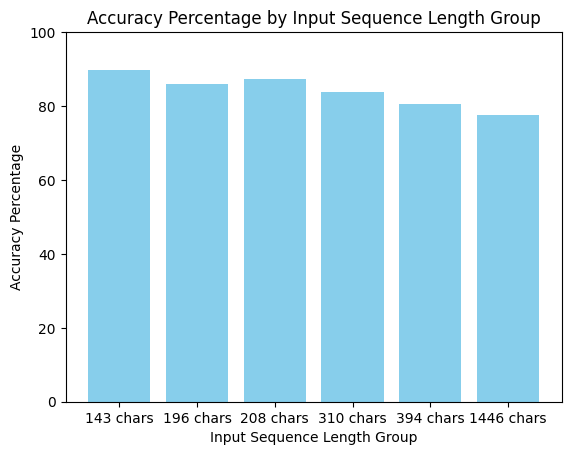

In [283]:
import numpy as np
import matplotlib.pyplot as plt

# Combine the sequences, true labels, and predicted labels into a list of tuples
data = list(zip(unseen_data, true_labels, y_unseen_pred))

# Sort the data based on the length of the input sequences
sorted_data = sorted(data, key=lambda x: len(x[0].split()))

# Define the number of groups
n_groups = 5

# Calculate the group size
group_size = len(sorted_data) // (n_groups + 1)

# Divide the sorted data into n_groups approximately equal-sized groups
groups = [sorted_data[i:i+group_size] for i in range(0, len(sorted_data), group_size)]
print(len(groups))
# Initialize counters for correctly predicted labels
group_correct = [0] * (n_groups + 1)

# Iterate through each group and count the number of correctly predicted labels
for i, group in enumerate(groups):
    for seq, true_label, pred_label in group:
        if true_label == pred_label:
            group_correct[min(i, len(group_correct) - 1)] += 1  # Ensure index doesn't exceed the length of group_correct

# Calculate accuracy percentage for each group
group_sizes = [len(group) for group in groups]
group_accuracies = [(correct / size) * 100 if size != 0 else 0 for correct, size in zip(group_correct, group_sizes)]

# Plot the results
# Calculate the amount of characters at the end of each group
end_char_counts = [len(group[-1][0]) for group in groups]
categories = [f'{end_char_count} chars' for end_char_count in end_char_counts]
print(categories)
accuracies = group_accuracies

plt.bar(categories, accuracies, color=['skyblue'])
plt.xlabel('Input Sequence Length Group')
plt.ylabel('Accuracy Percentage')
plt.title('Accuracy Percentage by Input Sequence Length Group')
plt.ylim(0, 100)
plt.show()


0 6825
3 369
1 756
2 126
4 299
disabled 834
migrant 882
poor-families 719
refugee 880
vulnerable 871
homeless 865
in-need 856
immigrant 843
hopeless 788
women 837


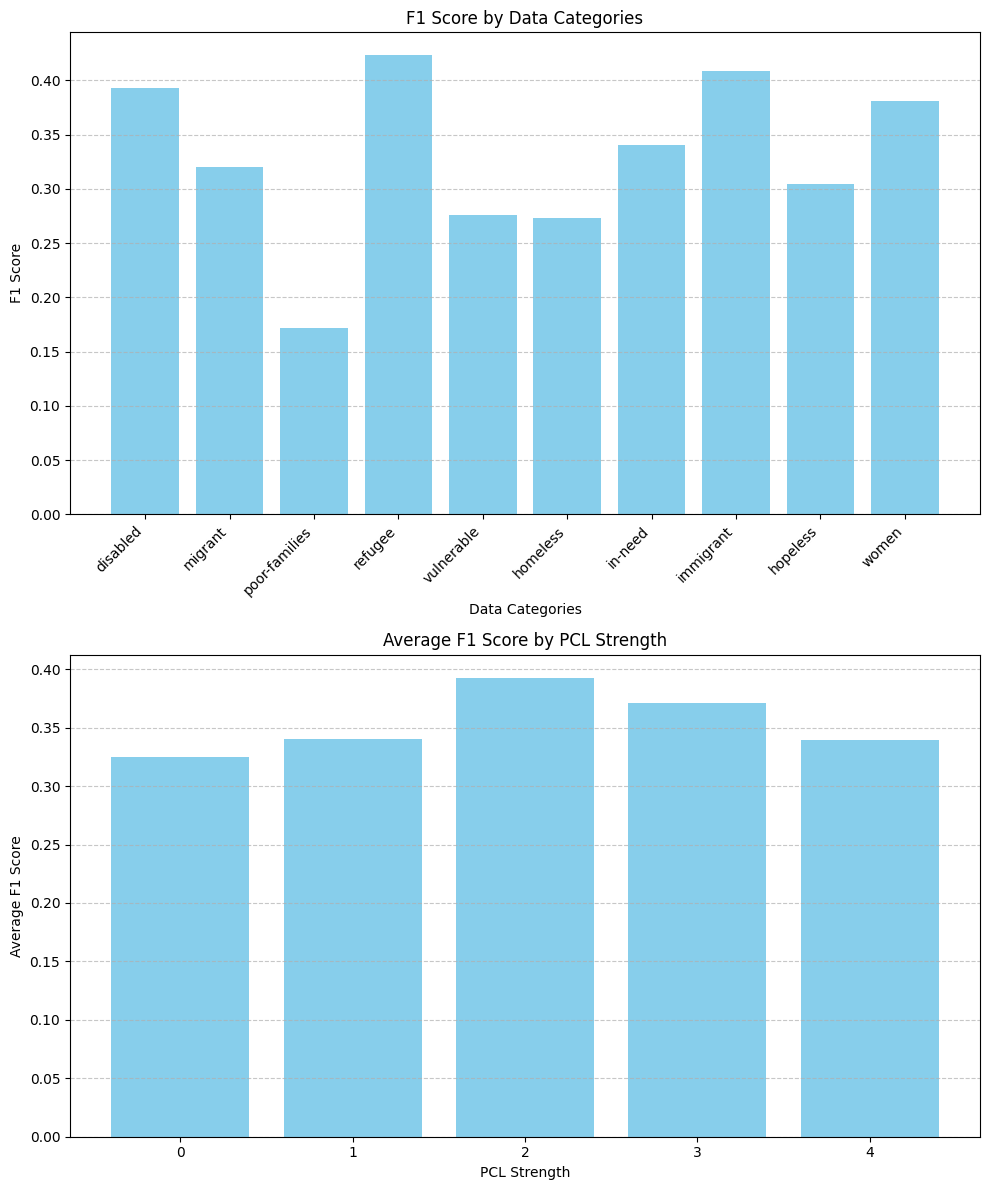

In [287]:
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.metrics import f1_score, accuracy_score

# Group data based on categories
data_categories = test_community  # True labels
pcl_strength = test_pcl
c2 = Counter(pcl_strength)
for k,v in c2.items():
    print(k,v)
c = Counter(data_categories)
for k,v in c.items():
    print(k, v)

category_data = {}
for category, true_label, pred_label, pcl_strength_val in zip(data_categories, true_labels, y_unseen_pred, pcl_strength):
    if category not in category_data:
        category_data[category] = {'true_labels': [], 'pred_labels': [], 'pcl_strength': []}
    category_data[category]['true_labels'].append(true_label)
    category_data[category]['pred_labels'].append(pred_label)
    category_data[category]['pcl_strength'].append(pcl_strength_val)

# Calculate F1 score for each category
category_f1_scores = {}
for category, data in category_data.items():
    category_f1_scores[category] = f1_score(data['true_labels'], data['pred_labels'])
    # category_f1_scores[category] = accuracy_score(data['true_labels'], data['pred_labels'])

# Plot the results
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 12))

# Plot for data_categories
axes[0].bar(range(len(category_f1_scores)), category_f1_scores.values(), color='skyblue')
axes[0].set_xlabel('Data Categories')
axes[0].set_ylabel('F1 Score')
axes[0].set_title('F1 Score by Data Categories')
axes[0].set_xticks(range(len(category_f1_scores)))
axes[0].set_xticklabels(list(category_f1_scores.keys()), rotation=45, ha='right')
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

# Plot for pcl_strength
pcl_strength_data = {}
for category, data in category_data.items():
    for pcl_strength_val, f1_score_val in zip(data['pcl_strength'], category_f1_scores.values()):
        if pcl_strength_val not in pcl_strength_data:
            pcl_strength_data[pcl_strength_val] = []
        pcl_strength_data[pcl_strength_val].append(f1_score_val)

# Sort pcl_strength_data by keys (PCL strength)
sorted_pcl_strength_data = dict(sorted(pcl_strength_data.items()))

axes[1].bar(range(len(sorted_pcl_strength_data)), [sum(scores)/len(scores) for scores in sorted_pcl_strength_data.values()], color='skyblue')
axes[1].set_xlabel('PCL Strength')
axes[1].set_ylabel('Average F1 Score')
axes[1].set_title('Average F1 Score by PCL Strength')
axes[1].set_xticks(range(len(sorted_pcl_strength_data)))
axes[1].set_xticklabels(sorted_pcl_strength_data.keys())
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()
